In [60]:
# Libraries
import gmmot
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal, gaussian_kde

## Transport between two GMM in 2D

In [61]:
# First distribution
K0 = 1
pi0 = np.array([1.])
m0 = np.array([0., 0.]).reshape(K0,2)
sigma0 = ((0.1)**2 * np.eye(2)).reshape(K0,2,2)

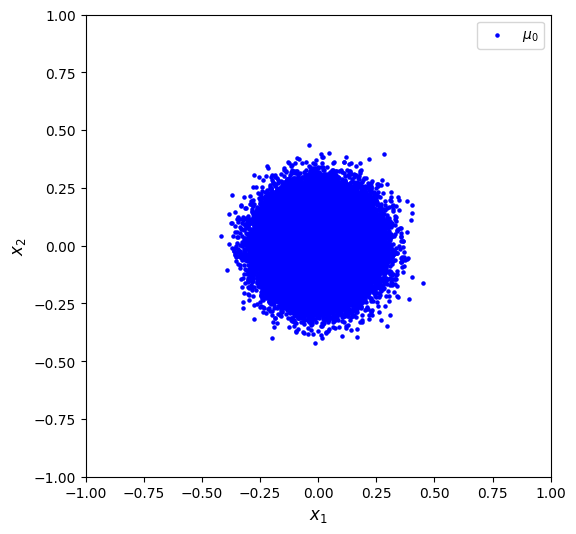

In [62]:
# Visualization of the first distribution
num_samples = 100000
samples = np.random.multivariate_normal(mean = m0[0], cov = sigma0[0], size = num_samples).T

plt.figure(figsize = (6,6))
plt.scatter(samples.T[:,0], samples.T[:,1], color = 'blue', s=5, label = r"$\mu_{0}$")
plt.xlabel(r"$x_{1}$", fontsize = 12)
plt.ylabel(r"$x_{2}$", fontsize = 12)
plt.xlim(-1., 1.)
plt.ylim(-1., 1.)
plt.legend()
plt.show()

In [63]:
# Second distribution (more complex)
np.random.seed(1)
K1 = 10
pi1 = np.random.dirichlet(np.ones(K1), size=1)[0]
m1 = np.array([
    [0, 0], [1, 1], [-1, -1], [2, 2], [-2, -2],
    [1, -1], [-1, 1], [3, 0], [0, 3], [-3, -3]
])

angles = np.linspace(0, np.pi, K1)
sigma1 = np.array([
    np.array([[np.cos(a), -np.sin(a)], [np.sin(a), np.cos(a)]]) @ np.diag([0.5, 0.2]) @
    np.array([[np.cos(a), np.sin(a)], [-np.sin(a), np.cos(a)]])
    for a in angles
])

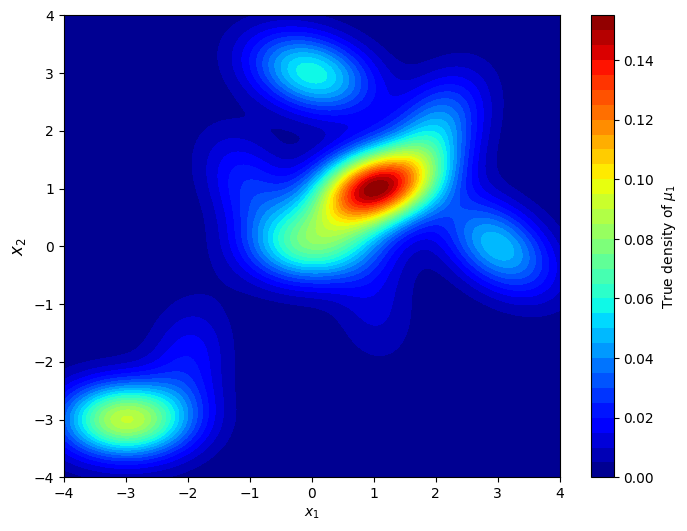

In [65]:
# Visualization of the second distribution
x_range = np.linspace(-4, 4, 200)
y_range = np.linspace(-4, 4, 200)
X, Y = np.meshgrid(x_range, y_range)
pos = np.dstack((X, Y))

Z = np.zeros(X.shape)
for i in range(K1):
    rv = multivariate_normal(mean = m1[i], cov = sigma1[i])
    Z += pi1[i] * rv.pdf(pos)

plt.figure(figsize = (8, 6))
plt.contourf(X, Y, Z, levels=30, cmap='jet')
plt.colorbar(label = r"True density of $\mu_{1}$")
plt.xlabel(r"$x_{1}$")
plt.ylabel(r"$x_{2}$", fontsize = 12)
plt.show()

In [66]:
# GMMOT
wstart, _ = gmmot.MW2(pi0, pi1, m0, m1, sigma0, sigma1)
transported_samples = gmmot.MW2TransportMap(pi0, pi1, m0, m1, sigma0, sigma1, wstart, samples)

100%|██████████| 100000/100000 [00:18<00:00, 5414.12it/s]


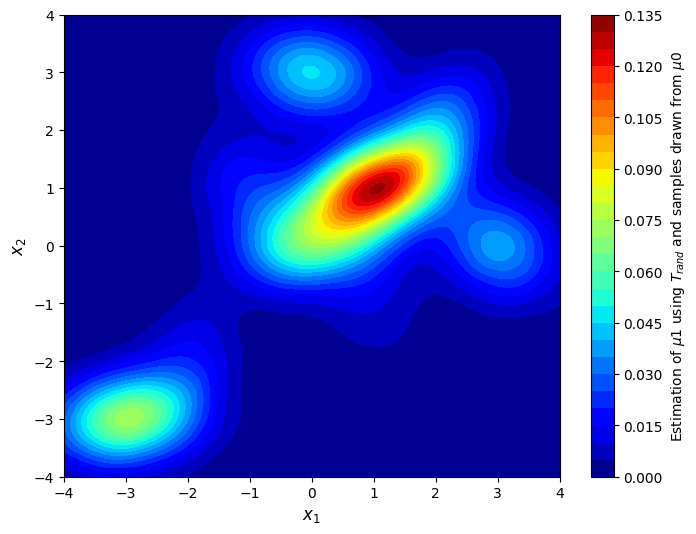

In [70]:
# Visualization of GMMOT
x, y = transported_samples.T[:,0], transported_samples.T[:,1]
kde = gaussian_kde(np.vstack([x, y]))
xmin, xmax = x.min() - 0.5, x.max() + 0.5
ymin, ymax = y.min() - 0.5, y.max() + 0.5
X, Y = np.meshgrid(np.linspace(xmin, xmax, 200), np.linspace(ymin, ymax, 200))
Z = kde(np.vstack([X.ravel(), Y.ravel()])).reshape(X.shape)

plt.figure(figsize = (8,6))
plt.contourf(X, Y, Z, levels = 30, cmap = "jet")
plt.xlabel(r"$x_{1}$", fontsize=12)
plt.ylabel(r"$x_{2}$", fontsize=12)
plt.xlim(-4.,4.)
plt.ylim(-4.,4.)
plt.colorbar(label = r"Estimation of $\mu{1}$ using $T_{rand}$ and samples drawn from $\mu{0}$")
plt.show()

## Transport between a GMM and a random distribution in 2D

In [79]:
# Distribution that is not a GMM
from sklearn.datasets import make_moons
X, _ = make_moons(n_samples = 2000, noise = 0.01, random_state = 42)

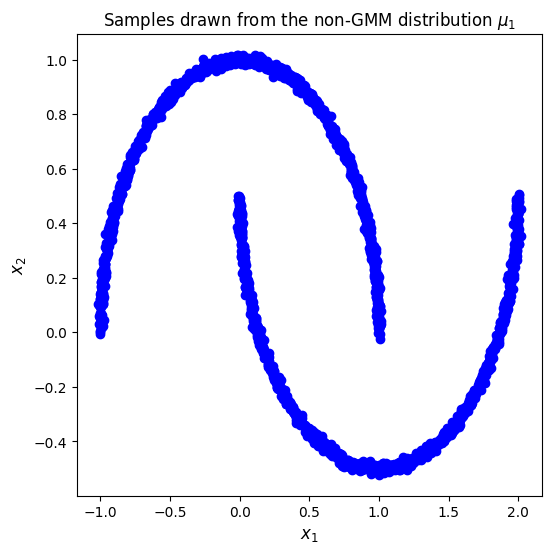

In [82]:
# Visualization of the non-GMM distribution
plt.figure(figsize = (6,6))
plt.scatter(X[:,0], X[:,1], color = 'blue')
plt.xlabel(r"$x_{1}$", fontsize=12)
plt.ylabel(r"$x_{2}$", fontsize=12)
plt.title(r"Samples drawn from the non-GMM distribution $\mu_{1}$", fontsize = 12)
plt.show()

In [132]:
# Fit a GMM on this non-GMM distribution
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components = 20, covariance_type = 'full', random_state = 42)
gmm.fit(X)
pi1 = gmm.weights_
m1 = gmm.means_
sigma1 = gmm.covariances_

In [133]:
# GMMOT between mu0 and the fitted distribution
samples = np.random.multivariate_normal(mean = m0[0], cov = sigma0[0], size = 2000).T
wstart, _ = gmmot.MW2(pi0, pi1, m0, m1, sigma0, sigma1)
transported_samples = gmmot.MW2TransportMap(pi0, pi1, m0, m1, sigma0, sigma1, wstart, samples)

100%|██████████| 2000/2000 [00:00<00:00, 5216.96it/s]


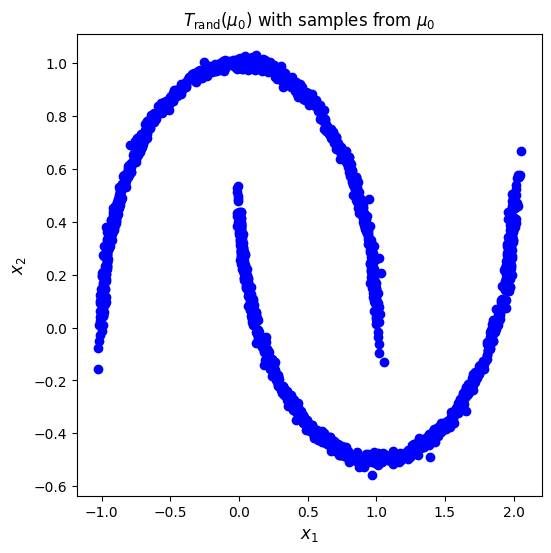

In [134]:
# Visualization of the non-GMM distribution
plt.figure(figsize = (6,6))
plt.scatter(transported_samples.T[:,0], transported_samples.T[:,1], color = 'blue')
plt.xlabel(r"$x_{1}$", fontsize=12)
plt.ylabel(r"$x_{2}$", fontsize=12)
plt.title(r"$T_{\text{rand}}(\mu_{0})$ with samples from $\mu_{0}$", fontsize = 12)
plt.show()

## Transport between a GMM and a random distribution in large dimensions

In [172]:
# Download MNIST
from torchvision import datasets, transforms
mnist = datasets.MNIST(root = "./data", train = True, download = True, transform = transforms.ToTensor())
images = np.array([np.array(img).reshape(-1) for img, _ in mnist])[:10000]

/tmp/ipykernel_24317/883566258.py:4: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  images = np.array([np.array(img).reshape(-1) for img, _ in mnist])[:10000]


In [173]:
# Fit a GMM on MNIST
gmm = GaussianMixture(n_components = 100, covariance_type = 'full', random_state = 42)
gmm.fit(images)
pi1 = gmm.weights_
m1 = gmm.means_
sigma1 = gmm.covariances_

In [174]:
# First distribution
K0 = 1
pi0 = np.array([1.])
m0 = np.zeros((1,784))
sigma0 = ((0.1)**2 * np.eye(784)).reshape(K0,784,784)

In [175]:
# GMMOT between mu0 and the fitted distribution
samples = np.random.multivariate_normal(mean = m0[0], cov = sigma0[0], size = 1).T
wstart, _ = gmmot.MW2(pi0, pi1, m0, m1, sigma0, sigma1)
transported_samples = gmmot.MW2TransportMap(pi0, pi1, m0, m1, sigma0, sigma1, wstart, samples)

/home/thomas/Bureau/Cours_MVA/S2/Image/Projet/Projet_Image/gmmot.py:65: ComplexWarning: Casting complex values to real discards the imaginary part
  M[i,j] = GaussianW2(m0[i], m1[j], sigma0[i], sigma1[j])
  0%|          | 0/1 [00:00<?, ?it/s]/home/thomas/Bureau/Cours_MVA/S2/Image/Projet/Projet_Image/gmmot.py:114: ComplexWarning: Casting complex values to real discards the imaginary part
  res[:,i] = GaussianTransportMap(m0[k], m1[l], sigma0[k], sigma1[l], x[:,i].reshape(d,1)).squeeze(-1)
100%|██████████| 1/1 [00:03<00:00,  3.52s/it]


100%|██████████| 1/1 [00:03<00:00,  3.17s/it]


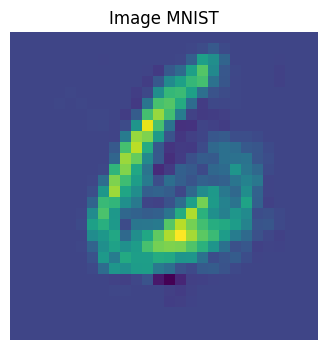

In [181]:
samples = np.random.multivariate_normal(mean = m0[0], cov = sigma0[0], size = 1).T
transported_samples = gmmot.MW2TransportMap(pi0, pi1, m0, m1, sigma0, sigma1, wstart, samples)
mnist_vector = transported_samples.squeeze(-1)
mnist_vector = mnist_vector - mnist_vector.min()  # Min = 0
mnist_vector = mnist_vector / mnist_vector.max()  # Max = 1

# 🔄 Reshape en (1, 28, 28)
mnist_image = mnist_vector.reshape(1, 28, 28)

# 🎨 Plot avec Matplotlib
plt.figure(figsize=(4,4))
plt.imshow(mnist_image[0])  # On enlève la première dimension pour afficher (28,28)
plt.axis("off")
plt.title("Image MNIST")
plt.show()